### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
- [Model Architecture](#1)
- [Dataset](#2)
- [Training pipeline](#3)
- [Testing pipeline](#3)

In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3080 Laptop GPU'

In [3]:
# generating a random seed
torch.manual_seed(21)
torch.cuda.manual_seed(21)

# Defining Hyperparamethers
cuda = True
batch_size = 64
lr = 0.001
epochs = 50


# importing the MNIST dataset
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64*7*7, 512) 
        self.bn5 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 1024)
        self.bn6 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 10)

        # Dropout Layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = x.view(x.size(0), -1) # Flatten the tensor
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout2(x)

        x = F.relu(self.bn6(self.fc2(x)))
        x = self.dropout2(x)

        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


In [5]:
model = Net()
# move the model to the GPU
if cuda: model.cuda()

Epoch 1, Loss: 0.14748413214978298
Epoch 2, Loss: 0.0696793487130442
Epoch 3, Loss: 0.05454845708500254
Epoch 4, Loss: 0.048360342552148446
Epoch 5, Loss: 0.041888971437558854
Epoch 6, Loss: 0.040137505696023826
Epoch 7, Loss: 0.033125346573013845
Epoch 8, Loss: 0.035631422611844064
Epoch 9, Loss: 0.031521035031907806
Epoch 10, Loss: 0.028219617578095005
Epoch 11, Loss: 0.0275224371538675
Epoch 12, Loss: 0.026911939247371394
Epoch 13, Loss: 0.023510427348310162
Epoch 14, Loss: 0.022913091899235582
Epoch 15, Loss: 0.02263195593357073
Epoch 16, Loss: 0.020251640050017873
Epoch 17, Loss: 0.01980233132743762
Epoch 18, Loss: 0.019102001093011953
Epoch 19, Loss: 0.017992946868012786
Epoch 20, Loss: 0.017479645819813937
Epoch 21, Loss: 0.01714145374540431
Epoch 22, Loss: 0.017274043417179977
Epoch 23, Loss: 0.016039836360777892
Epoch 24, Loss: 0.014593130638681815
Epoch 25, Loss: 0.014253301139967475
Epoch 26, Loss: 0.014034599708598987
Epoch 27, Loss: 0.012809118439649098
Epoch 28, Loss: 0.0

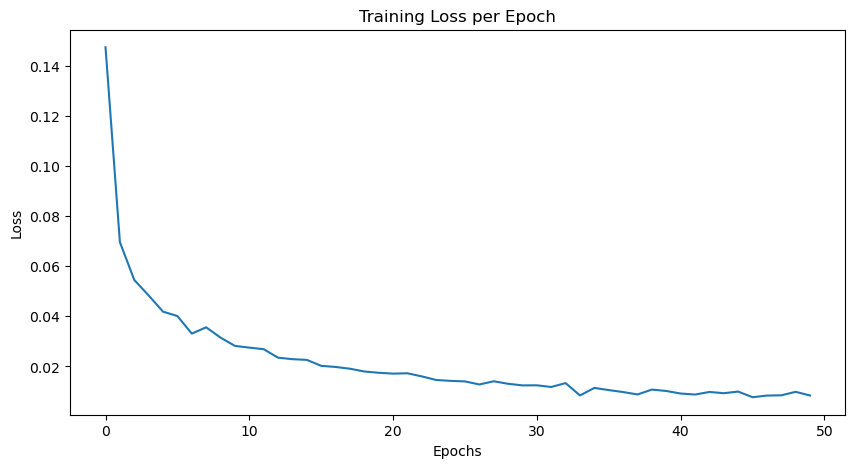

In [6]:
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Check if CUDA is available and set PyTorch to use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() and cuda else "cpu")

# Initialize the model, optimizer, and loss function
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss() # Equivalent of "categorical_crossentropy" in PyTorch

# List to store the loss values at each epoch
loss_values = []

# Training loop
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0): # Assuming you have a DataLoader 'trainloader'
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
    loss_values.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

print('Finished Training')

# Plotting the loss values
plt.figure(figsize=(10,5))
plt.title("Training Loss per Epoch")
plt.plot(loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
        

Accuracy of the network on the test images: 99 %


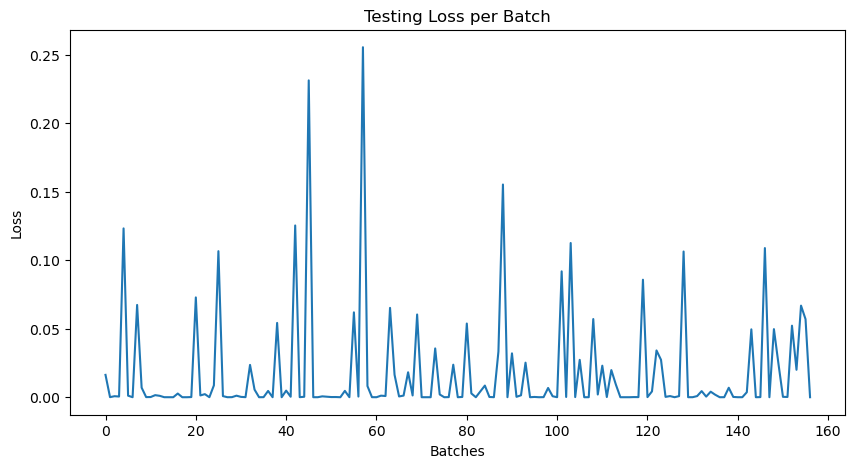

In [8]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track predictions and target values
total = 0
correct = 0

# Initialize the list to store the losses
test_loss_values = []

# We don't need to track gradients during testing
with torch.no_grad():
    for data in test_loader: # Assuming you have a DataLoader 'testloader'
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Make predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Track the number of correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Compute and track the loss
        loss = criterion(outputs, labels)
        test_loss_values.append(loss.item())

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

# Plotting the loss values
plt.figure(figsize=(10,5))
plt.title("Testing Loss per Batch")
plt.plot(test_loss_values)
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.show()

In [9]:
100 * correct / total

99.57